<a href="https://colab.research.google.com/github/Arthuric367/Automated-Job-Aggregator-and-Enrichment-Bot/blob/main/Sentiment_Analysis_with_Web.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ngrok


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.89


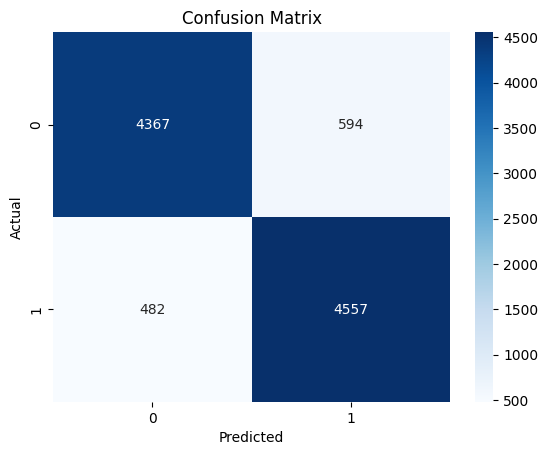

Prediction for sample text: positive
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Streamlit app is live at: NgrokTunnel: "https://841d3a1f1d9c.ngrok-free.app" -> "http://localhost:8501"


In [8]:
# Cell 1: Install required libraries
!pip install streamlit pyngrok -q
!pip install pandas numpy scikit-learn nltk -q  # Ensure libraries are installed
!wget -q https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
!tar -xvzf ngrok-v3-stable-linux-amd64.tgz -C /usr/local/bin
!chmod +x /usr/local/bin/ngrok

# Cell 2: Train model, save it, and show confusion matrix
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Download NLTK stopwords
nltk.download('stopwords')

# Load data
data = pd.read_csv('/content/sample_data/IMDB Dataset.csv')
reviews = data['review']
labels = data['sentiment']  # 'negative' or 'positive'

# Preprocess text
stop_words = set(stopwords.words('english'))
def preprocess(text):
    return ' '.join(word.lower() for word in text.split() if word.lower() not in stop_words)

reviews = reviews.apply(preprocess)

# Convert text to numerical features
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(reviews)
y = labels

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate
predictions = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions):.2f}")

# Show confusion matrix
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Predict on new text
new_text = ["This movie was amazing!"]
new_text_transformed = vectorizer.transform(new_text)
print(f"Prediction for sample text: {model.predict(new_text_transformed)[0]}")

# Save model and vectorizer
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Cell 3: Write Streamlit app
app_code = """
import streamlit as st
import pickle
import nltk
from nltk.corpus import stopwords
import string

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load model and vectorizer
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)
with open('vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

# Preprocess function
def preprocess(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Streamlit app
st.title("Movie Review Sentiment Analysis")
st.write("Enter a movie review to predict its sentiment (positive or negative).")

# Input text
user_input = st.text_area("Enter your review:", "Type your movie review here...")

if st.button("Predict Sentiment"):
    if user_input:
        # Preprocess and predict
        processed_input = preprocess(user_input)
        input_vector = vectorizer.transform([processed_input])
        prediction = model.predict(input_vector)[0]
        sentiment = 'positive' if prediction == 'positive' else 'negative'
        st.write(f"Predicted Sentiment: **{sentiment}**")
    else:
        st.write("Please enter a review.")
"""
with open('app.py', 'w') as f:
    f.write(app_code)

# Cell 4: Run Streamlit with ngrok
from pyngrok import ngrok
import subprocess

# Set ngrok authtoken
!ngrok authtoken 2zwhy33I9ElIYpfLPxzwzMwcCZ2_6kPB1GvYwvxpWakwFZbt8

# Terminate any existing ngrok tunnels
ngrok.kill()

# Start Streamlit server
subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501"])

# Create ngrok tunnel
public_url = ngrok.connect(8501)
print(f"Streamlit app is live at: {public_url}")